# Ground state search for the $J_1$-$J_2$ model
we study the spin-$1/2$  $J_1$-$J_2$ model on the square lattice, a common benchmark for NQS.
The Hamiltonian is 
$$
    H = J_1\sum_{\langle i,j \rangle} \mathbf{S}_i \cdot \mathbf{S}_j + J_2 \sum_{\langle \langle i,j \rangle \rangle} \mathbf{S}_i \cdot \mathbf{S}_j,
$$
where $\mathbf{S}_i = (S_i^x, S_i^y, S_i^z)$ denotes the spin-$1/2$ operator at site $i=1,...,L^2$, and, $\langle...\rangle$, $\langle \langle...\rangle \rangle$ respectively indicate pairs of nearest and next-nearest neighbors sites.

It has been shown that finding the ground state of this model close to the point of maximum frustration $J_2/J_1 = 0.5$ is a hard problem for NQS, and we will see if importance sampling can improve the result we get. We will keep the lattice size small (4x4) for computational reasons.

This notebook takes approximately 30 minutes to run on a modern GPU. You can lower the iteration number or the sample size if you want a demonstration of the same result in less time.

In [1]:
import netket as nk 
import matplotlib.pyplot as plt 
import optax
import jax.numpy as jnp
from netket.callbacks import InvalidLossStopping

import advanced_drivers as advd
from deepnets.net import ViT2D
from grad_sample.models import Square_Heisenberg
from grad_sample.utils import e_diag, save_exact_err

### VMC hyperparameters
Here we define the main parameters for Variational Monte Carlo (VMC):
- number of samples, which should be between $2^9$ and $2^{14}$
- number of iterations
- learning rate
- diagonal shift to remove singularities in the estimated QGT. To improve the training stability, we use a linear scheduler starting with a large value and progressively decreasing to $10^{-4}$ for improved precision

In [2]:
# Define VMC hparams
Ns = 2**12
n_iter = 2000

lr = optax.linear_schedule(init_value = 0.005,
                            transition_steps = 300,
                            end_value= 0.001) 
                 
diag_shift = optax.linear_schedule(init_value= 0.01,
                                transition_steps= 200,
                                end_value= 1e-4) 

opt = optax.sgd(learning_rate=lr)

### Model and ansatz
- We define the spin-$1/2$  $J_1$-$J_2$ model without using the Marshall sign rule to change the basis.
- To speed up the computations, we don't resort to Metropolis sampler, but to the exact one.
- As an ansatz, we will use a Vision Tranformer (see paper by Viteritti et al.) with 3 layers, 16 hidden features, 4 heads and a linear patch size of 1. Usually, the employed linear patch size is two, but on the 4x4 we found out using a patch size of 1 worked better.

In [3]:
model = Square_Heisenberg(J= [1.0, 0.5], L=4, sign_rule= [0.0, 0.0])

def create_vstate():
    ansatz = ViT2D(system = model, 
                depth=3,
                    d_model= 16,
                    heads= 4,
                    linear_patch_size=1,
                    output_head_name= "Vanilla",
                    expansion_factor=1)

    sampler = nk.sampler.ExactSampler(hilbert = model.hilbert_space)

    vstate = nk.vqs.MCState(sampler= sampler, 
                            model=ansatz.network, 
                            n_samples= Ns,
                            seed=0
                            )
    return vstate



As a reference for the optimization, we compute the exact ground state energy

In [4]:
E_gs = e_diag(model.hamiltonian.to_sparse())
print('The ground state energy is %.4f'%E_gs)

-33.831693405579436


## Testing importance sampling
We will compare 3 sampling strategies:
- the usual one where we sample from $|\psi|^2$
- sampling from $|\psi|$
- adaptive tuning of the overdispersion coefficient $|\psi|^\alpha$

For a fair comparison, we will compute the variational energies in exact summation.

### Sampling from $|\psi|^2$
Let's start by the usual case where we sample from the Born amplitude

In [5]:
vstate = create_vstate()
driver = advd.driver.VMC_NG(hamiltonian=model.hamiltonian.to_jax_operator(), 
                            optimizer=opt, 
                            variational_state=vstate, 
                            diag_shift=diag_shift, 
                            use_ntk=False,
                            on_the_fly=False)

out_psi_sq = nk.logging.RuntimeLog()
fs_state_err = nk.vqs.FullSumState(hilbert = vstate.hilbert, 
                                        model = vstate.model,  
                                        seed=0)
driver.run(n_iter = n_iter, out = out_psi_sq, 
           callback = (InvalidLossStopping(), 
            save_exact_err(fs_state_err, E_gs, save_every=10)))

100%|█| 2000/2000 [10:17<00:00,  3.24it/s, Energy=-33.5-


(RuntimeLog():
  keys = ['Energy', 'rel_err'],)

### Sampling from $|\psi|$
Now, we can test what Chen and Heyl proposed in the MinSR paper that is to sample from the modulus of the neural wave function.

In [7]:
modulus_distribution = advd.driver.overdispersed_distribution(alpha=1.0)
vstate = create_vstate()
driver =advd.driver.VMC_NG(hamiltonian=model.hamiltonian.to_jax_operator(), 
                            optimizer=opt, 
                            sampling_distribution = modulus_distribution, #here we specified the new sampling distribution
                            variational_state=vstate, 
                            diag_shift=diag_shift, 
                            use_ntk=False,
                            on_the_fly=False)

out_psi_mod = nk.logging.RuntimeLog()
fs_state_err = nk.vqs.FullSumState(hilbert = vstate.hilbert, 
                                    model = vstate.model,  
                                    seed=0)
driver.run(n_iter = n_iter, out = out_psi_mod, callback = (InvalidLossStopping(), save_exact_err(fs_state_err, E_gs, save_every=10)))

100%|█| 2000/2000 [11:16<00:00,  2.96it/s, Energy=-33.83


(RuntimeLog():
  keys = ['Energy', 'rel_err'],)

### Adaptive tuning
Now let's try adaptive tuning of the overdispersion factor to see if we gain any extra benefit from it. We initialize the distribution to be the Born distribution.

In [9]:
modulus_distribution = advd.driver.overdispersed_distribution(alpha=2.0) 
vstate = create_vstate()
driver =advd.driver.VMC_NG(hamiltonian=model.hamiltonian.to_jax_operator(), 
                            optimizer=opt, 
                            sampling_distribution = modulus_distribution, #here we specified the new sampling distribution
                            variational_state=vstate, 
                            diag_shift=diag_shift, 
                            auto_is=True, #this will call the adaptive tuning step
                            use_ntk=False,
                            on_the_fly=False)

out_psi_auto = nk.logging.RuntimeLog()
fs_state_err = nk.vqs.FullSumState(hilbert = vstate.hilbert, 
                                    model = vstate.model,  
                                    seed=0)
driver.run(n_iter = n_iter, out = out_psi_auto, callback = (InvalidLossStopping(), save_exact_err(fs_state_err, E_gs, save_every=10)))

100%|█| 2000/2000 [16:02<00:00,  2.08it/s, Energy=-33.83


(RuntimeLog():
  keys = ['Energy', 'info', 'rel_err'],)

### Let's compare !

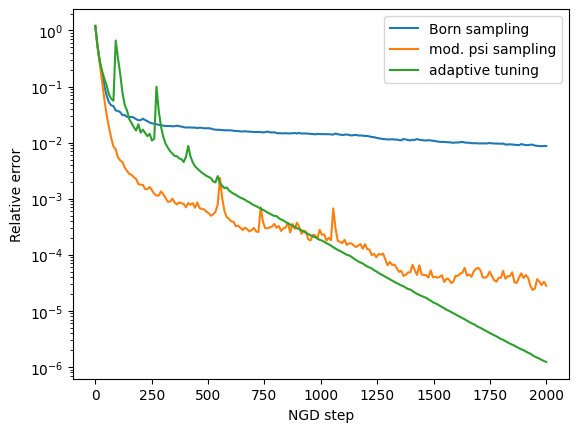

In [10]:
plt.plot(jnp.linspace(0,n_iter,n_iter//10), out_psi_sq['rel_err'], label = 'Born sampling')
plt.plot(jnp.linspace(0,n_iter,n_iter//10), out_psi_mod['rel_err'], label = 'mod. psi sampling')
plt.plot(jnp.linspace(0,n_iter,n_iter//10), out_psi_auto['rel_err'], label = 'adaptive tuning')

plt.ylabel('Relative error')
plt.xlabel('NGD step')

plt.yscale('log')

plt.legend()
plt.show()

Let's look at the adaptive tuning trajectory as well:

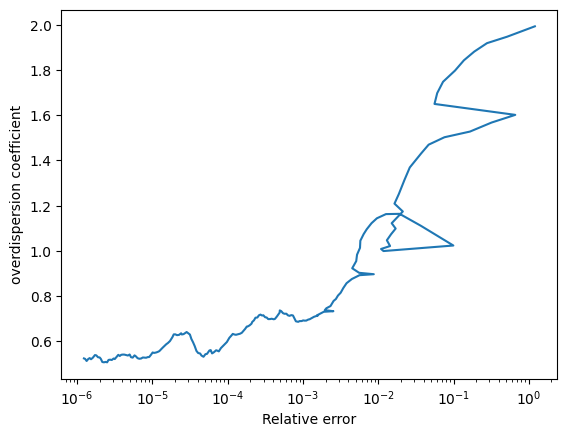

In [14]:
plt.plot(out_psi_auto['rel_err'], out_psi_auto['info']['alpha'][::10])
plt.xlabel('Relative error')
plt.ylabel('overdispersion coefficient')
plt.xscale('log')